In [1]:
import pandas as pd
import h5py
from tqdm import tqdm
import random
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.serif": ["Computer Modern Roman"]})

# from utils import global_convexity_violation_holm
from utils import global_convexity_violation
from meta_feature import dataset_ids_CC18, anchor_list_denser, feature_num_CC18, class_num_CC18, learner_zoo

In [2]:
file_paths = [  '../dataset/LCDB11_ER_CC18_noFS_raw.hdf5',
                '../dataset/LCDB11_ER_CC18_minmaxFS_raw.hdf5',
                '../dataset/LCDB11_ER_CC18_standardFS_raw.hdf5']
dataset_nofs, dataset_minmaxfs, dataset_standardfs = [h5py.File(fp, 'r')['error_rate'][...] for fp in file_paths]


In [3]:
conv_matrix_nofs, conv_h_matrix_nofs, conv_i_matrix_nofs, conv_j_matrix_nofs = global_convexity_violation(dataset_nofs)
conv_matrix_minmaxfs, conv_h_matrix_minmaxfs, conv_i_matrix_minmaxfs, conv_j_matrix_minmaxfs = global_convexity_violation(dataset_minmaxfs)
conv_matrix_standardfs, conv_h_matrix_standardfs, conv_i_matrix_standardfs, conv_j_matrix_standardfs = global_convexity_violation(dataset_standardfs)

  0%|          | 0/72 [00:00<?, ?it/s]c:\Users\cyan1\code\lcdb1.1\analysis\utils.py:530: RuntimeWarning: Mean of empty slice
  mean_curve = np.nanmean(curves_group, axis=0)
  3%|▎         | 2/72 [00:04<02:57,  2.53s/it]C:\Users\cyan1\AppData\Roaming\Python\Python311\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
100%|██████████| 72/72 [01:31<00:00,  1.28s/it]


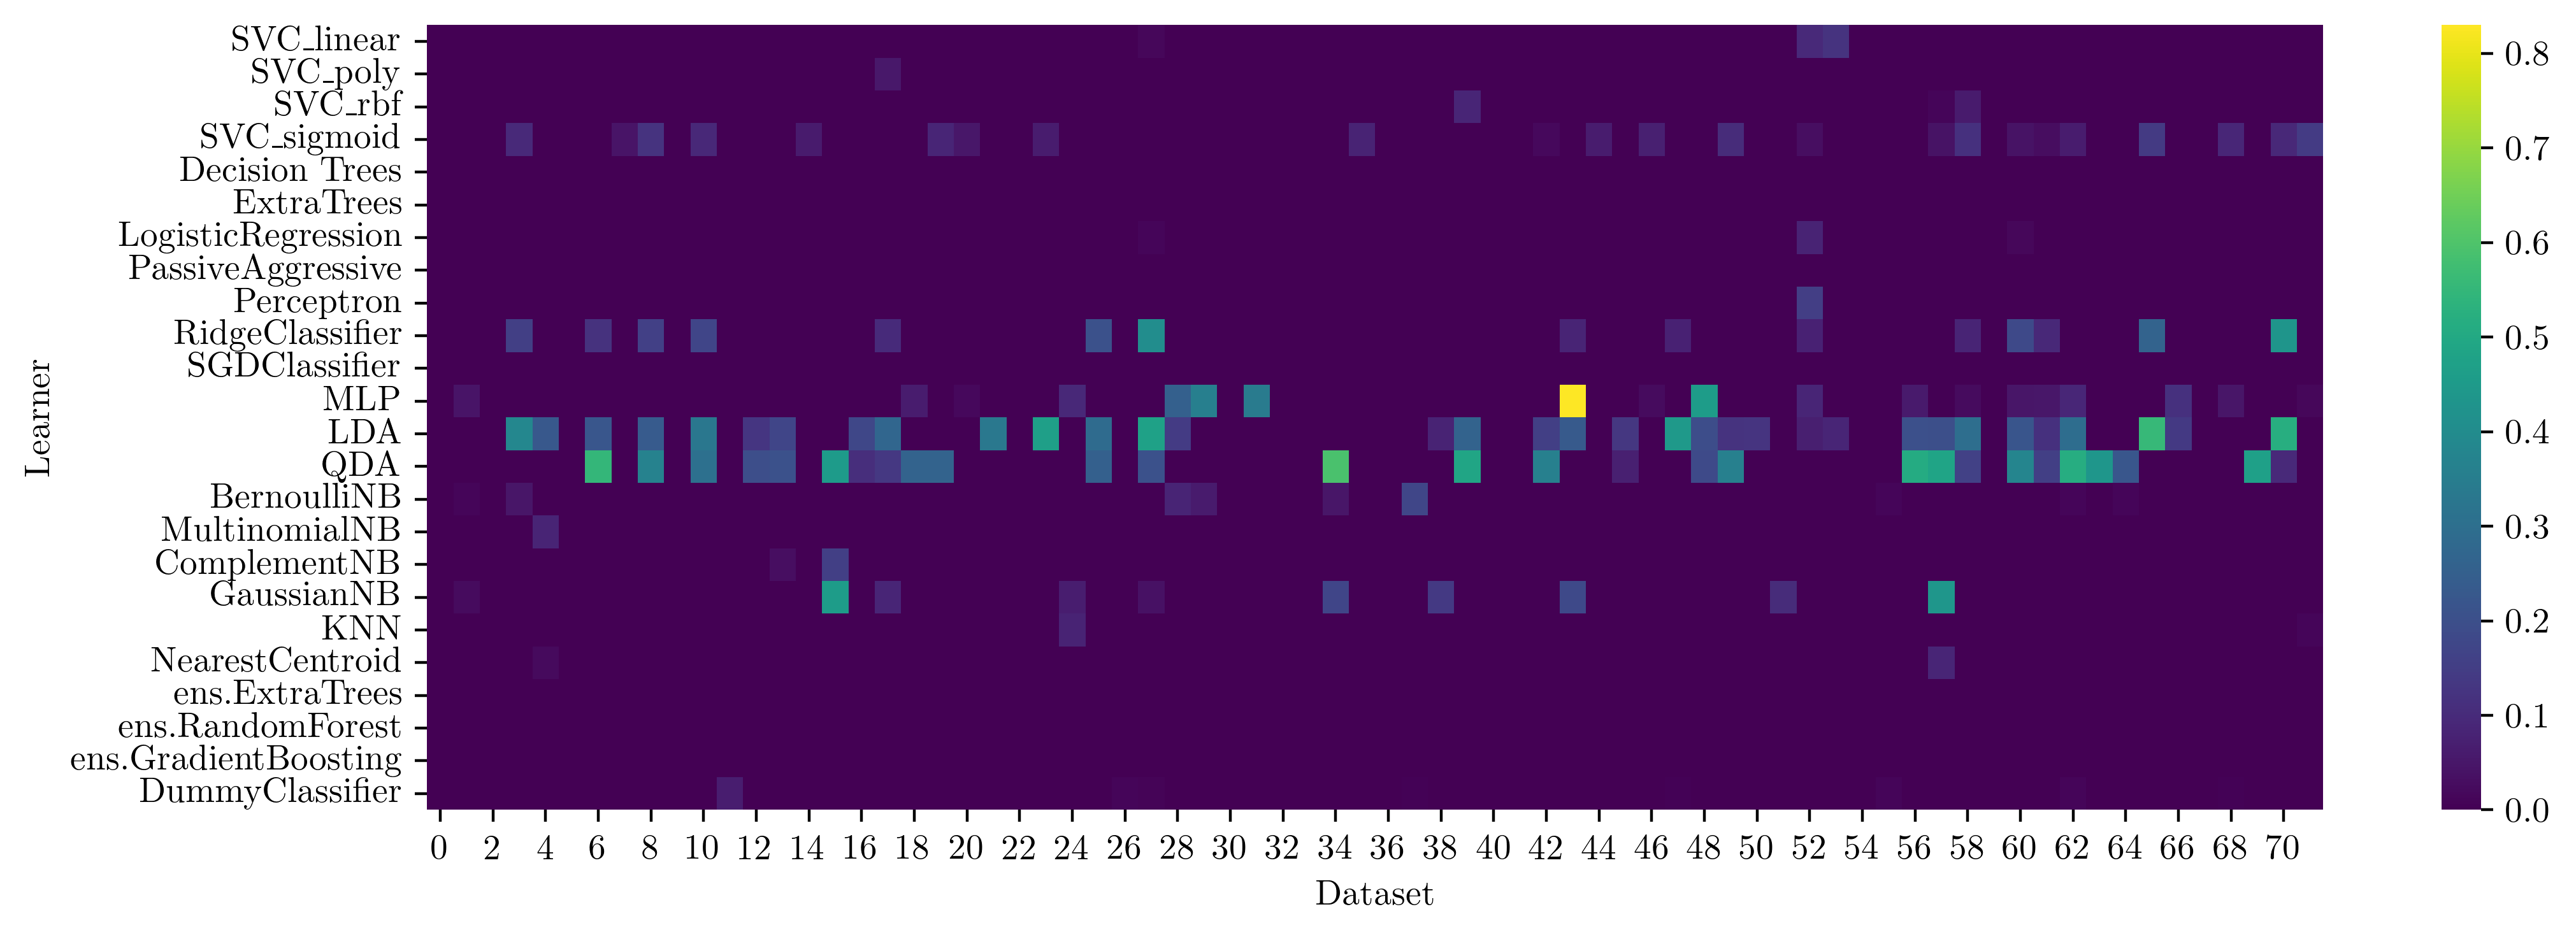

In [4]:
plt.figure(figsize=(12, 4), dpi=400)
ax = sns.heatmap(conv_matrix_nofs, cmap="viridis", annot=False, cbar=True)
# y tick align
yticks = range(len(learner_zoo))
ax.set_yticks([y + 0.5 for y in yticks])
ax.set_yticklabels(learner_zoo, rotation=0)

plt.xlabel('Dataset')
plt.ylabel('Learner')
plt.show()

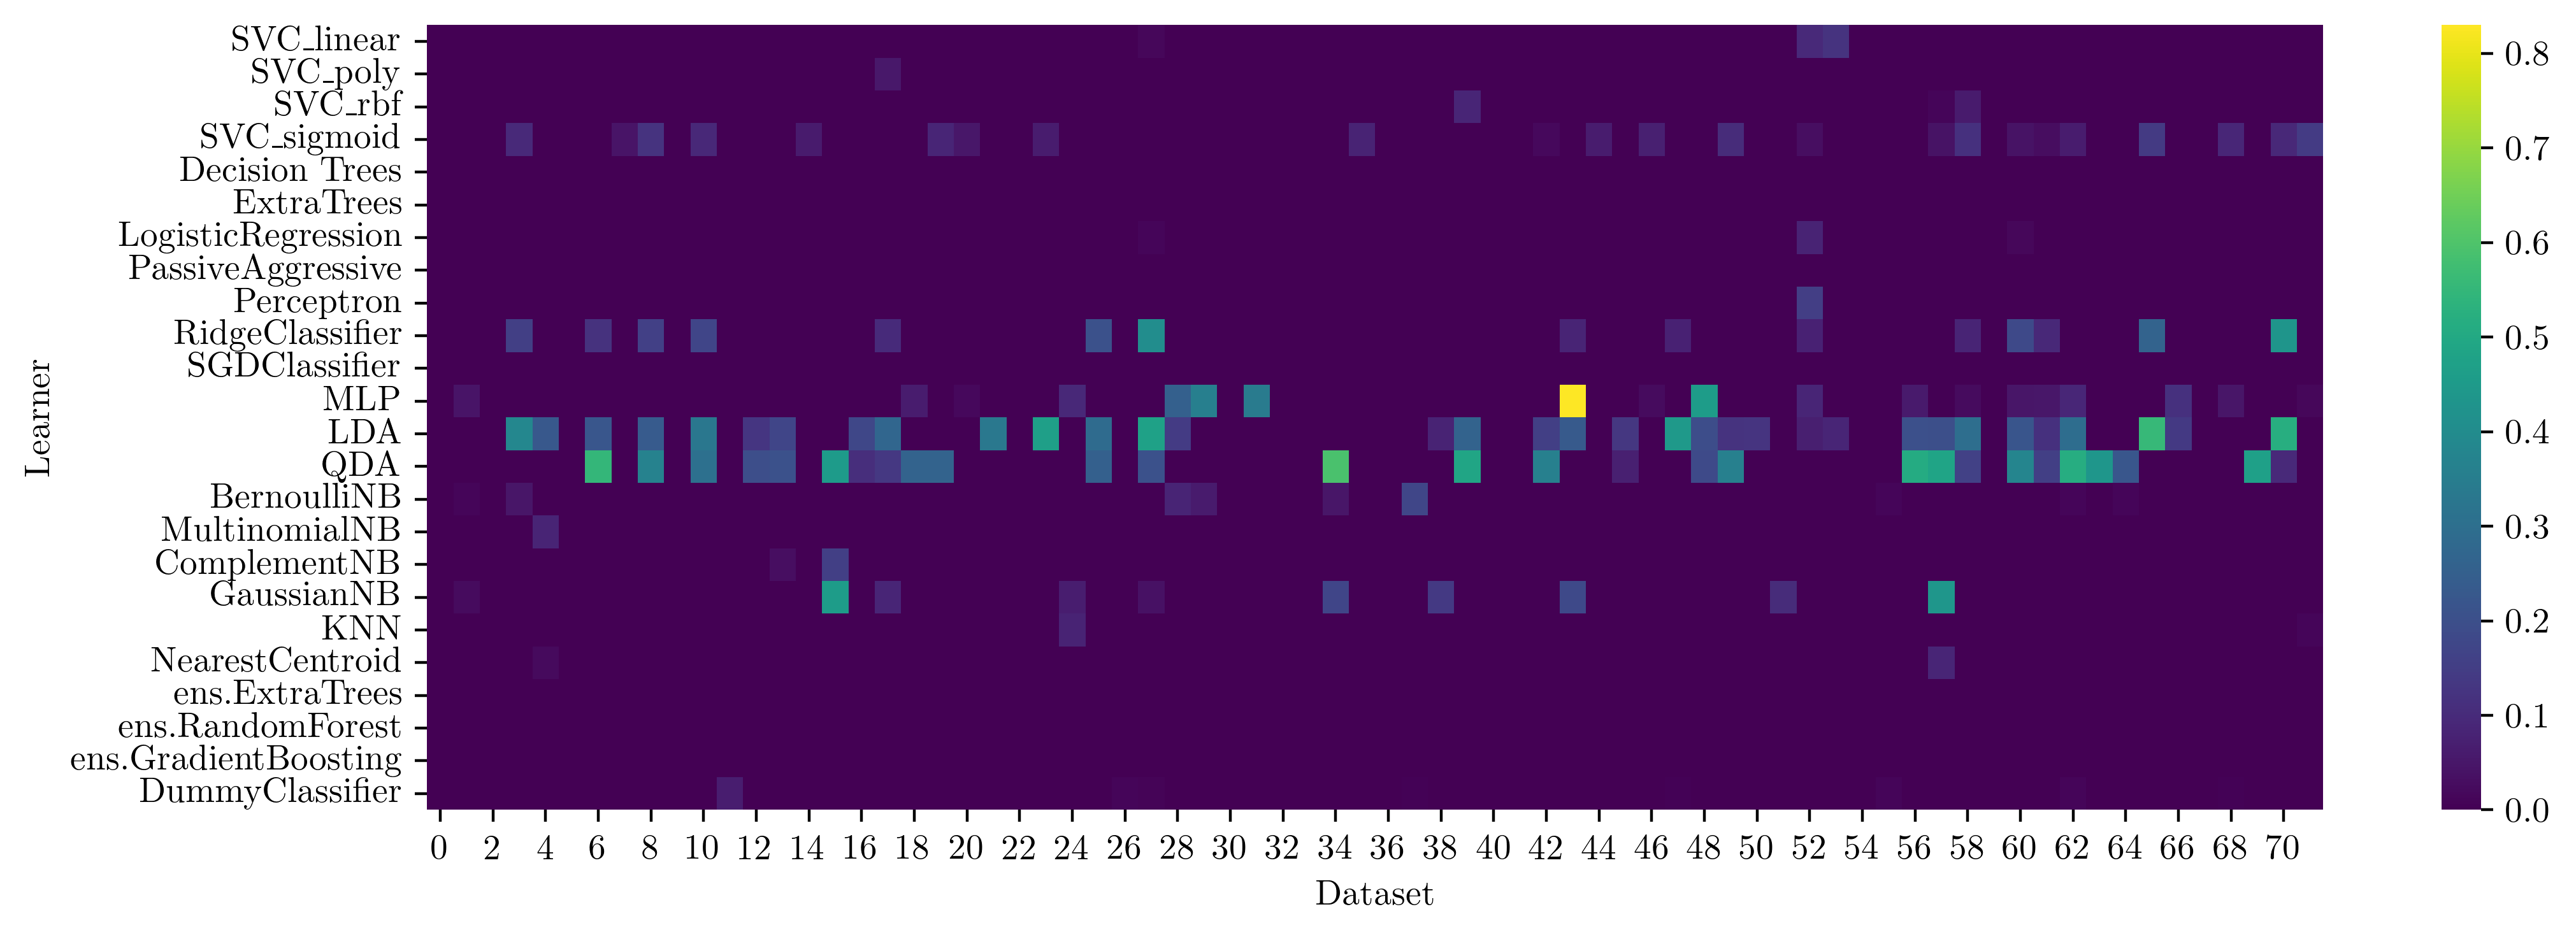

In [5]:
plt.figure(figsize=(12, 4), dpi=400)
ax = sns.heatmap(conv_matrix_nofs, cmap="viridis", annot=False, cbar=True)
# y tick align
yticks = range(len(learner_zoo))
ax.set_yticks([y + 0.5 for y in yticks])
ax.set_yticklabels(learner_zoo, rotation=0)

plt.xlabel('Dataset')
plt.ylabel('Learner')
plt.show()

In [6]:
percentages_nofs = (np.sum(conv_matrix_nofs > 0, axis=1) / conv_matrix_nofs.shape[1]) * 100
percentages_minmaxfs = (np.sum(conv_matrix_minmaxfs > 0, axis=1) / conv_matrix_minmaxfs.shape[1]) * 100
percentages_standardfs = (np.sum(conv_matrix_standardfs > 0, axis=1) / conv_matrix_standardfs.shape[1]) * 100


# filter some learner
exclude_indices = [13, 14, 15, 16, 17, 18, 23]      # list(range(14, 18))  no Naive Bayes  13 QDA  23 DUMMY
learner_zoo_filtered = [learner for i, learner in enumerate(learner_zoo) if i not in exclude_indices]
percentages_nofs = [val for i, val in enumerate(percentages_nofs) if i not in exclude_indices]
percentages_minmaxfs = [val for i, val in enumerate(percentages_minmaxfs) if i not in exclude_indices]
percentages_standardfs = [val for i, val in enumerate(percentages_standardfs) if i not in exclude_indices]

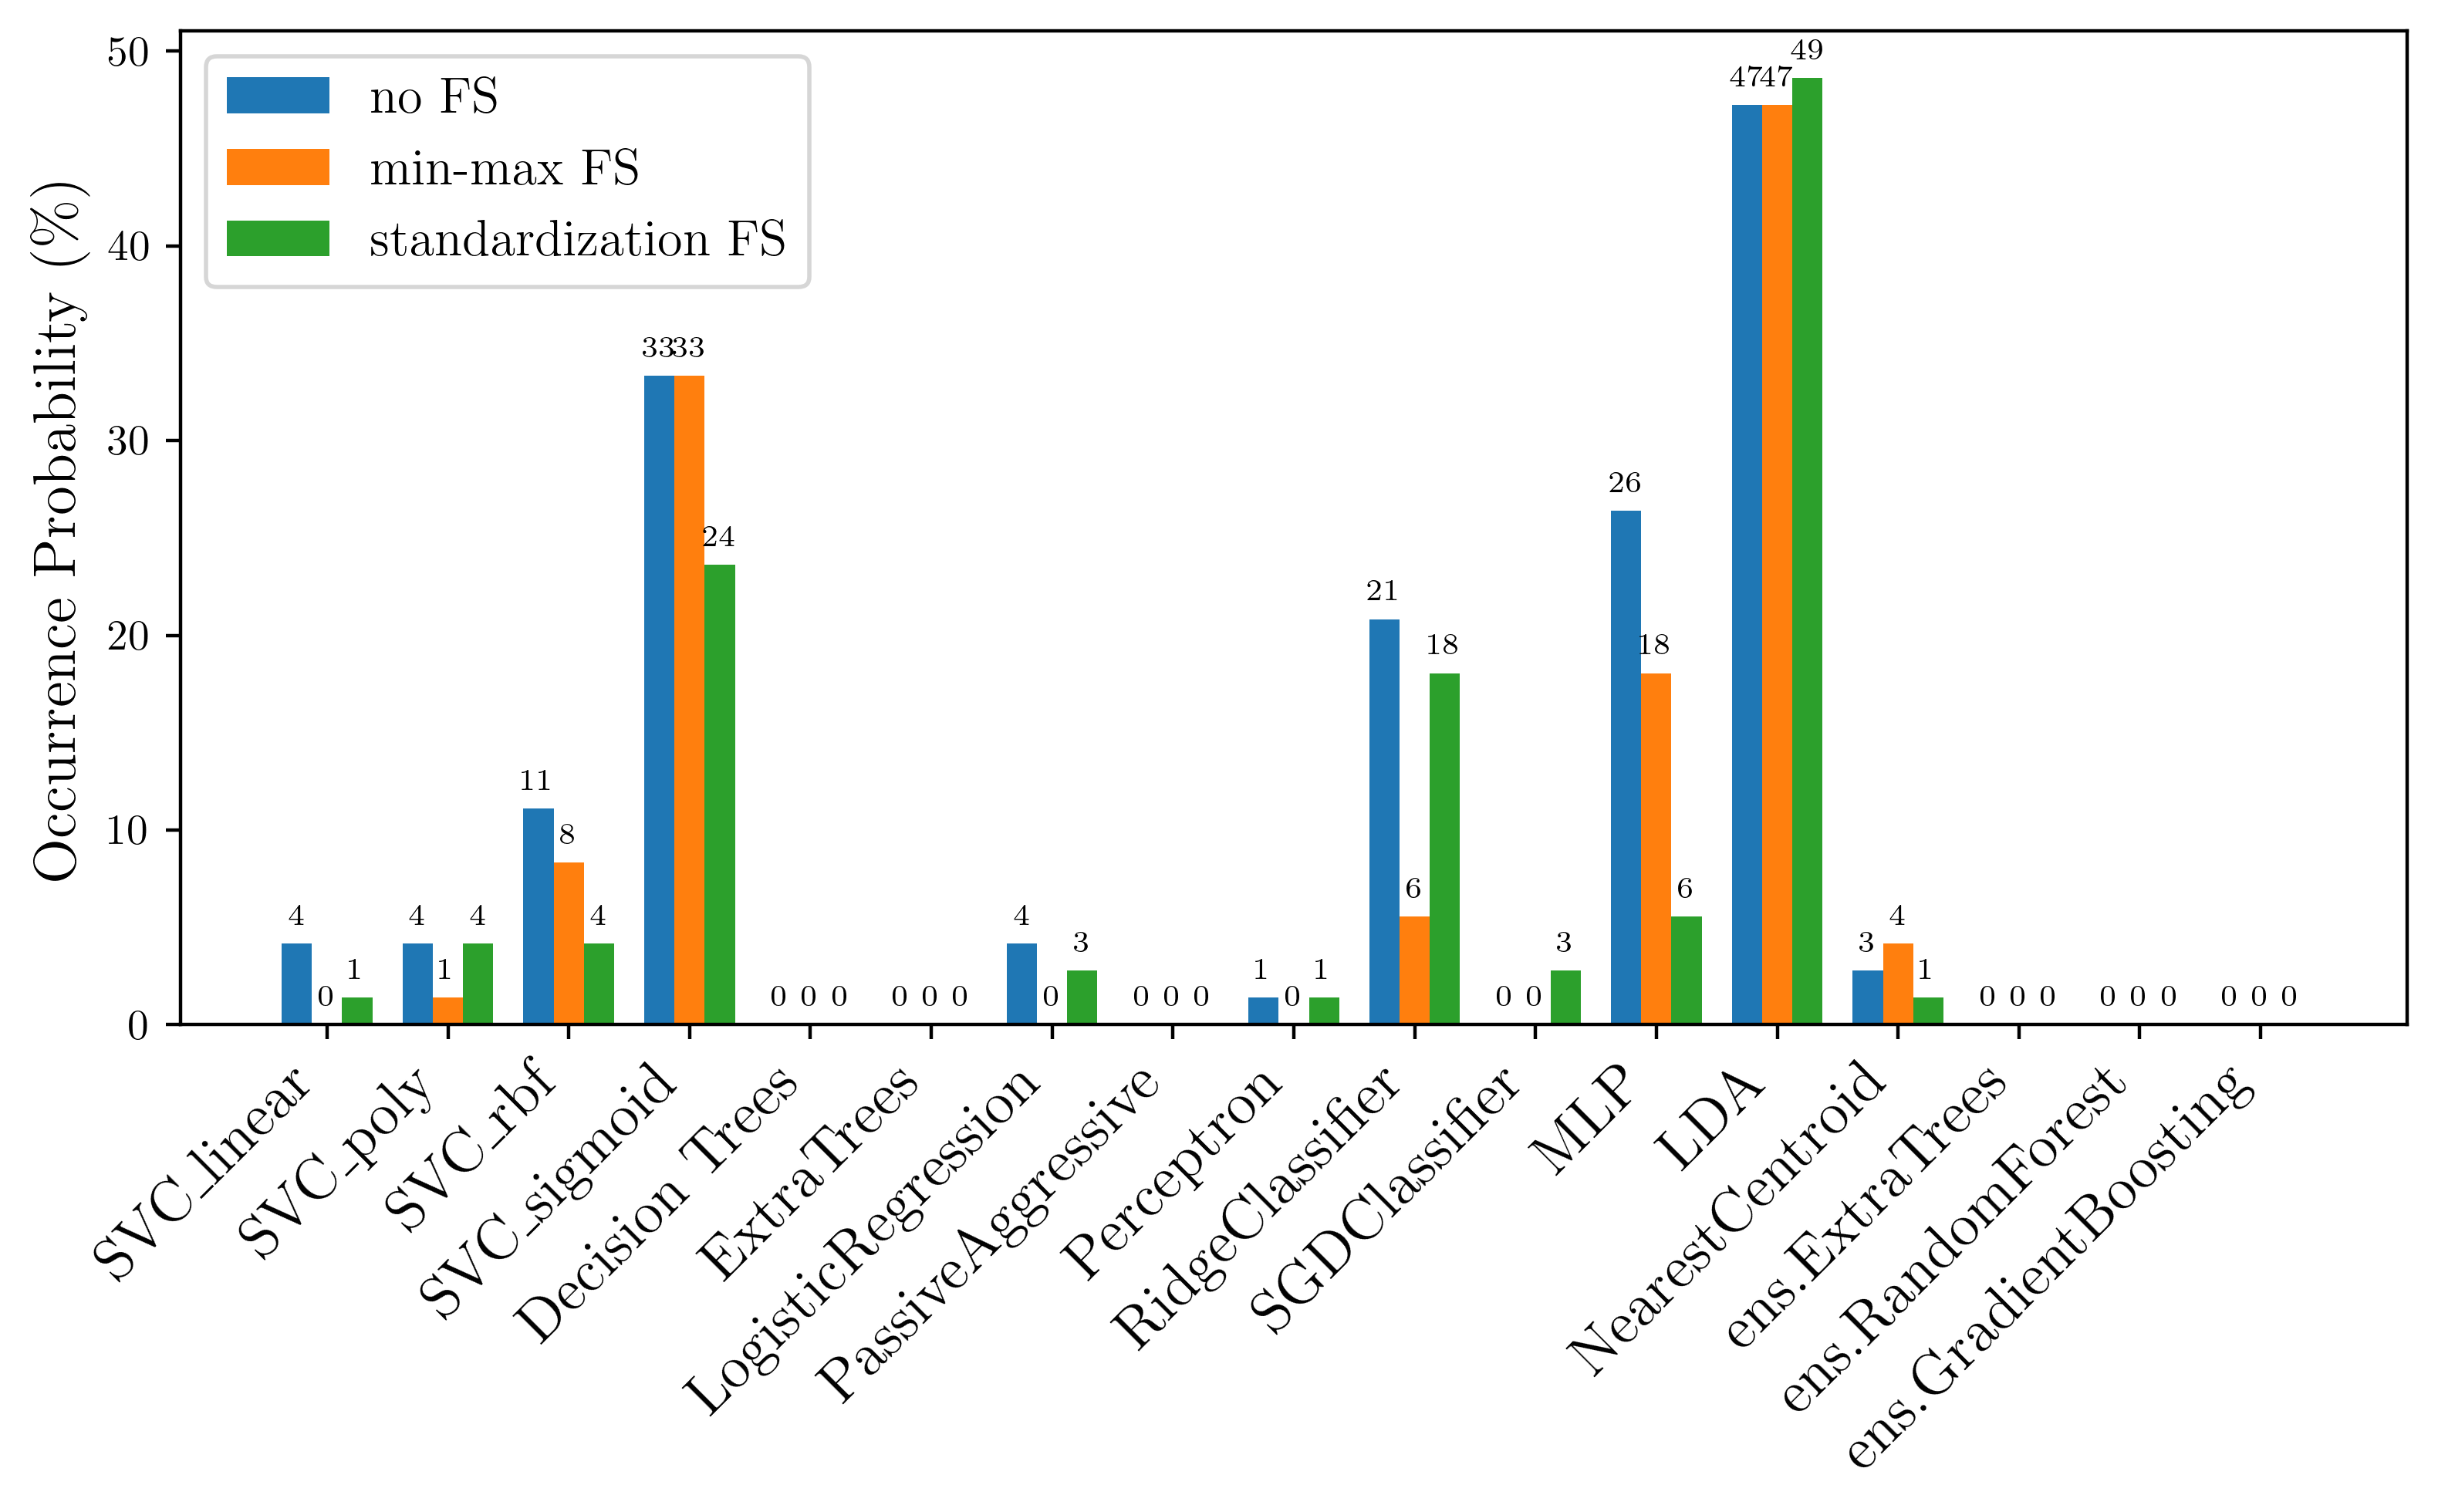

In [7]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=400)

width = 0.25
x = np.arange(len(learner_zoo_filtered))  

bar1 = ax.bar(x - width,    percentages_nofs,       width, label='no FS')
bar2 = ax.bar(x ,           percentages_minmaxfs,   width, label='min-max FS')
bar3 = ax.bar(x + width,    percentages_standardfs, width, label='standardization FS')

ax.set_ylabel(r'Occurrence Probability (\%)', fontsize = 14)
ax.set_xticks(x)
ax.set_xticklabels(learner_zoo_filtered, rotation=45, ha='right', fontsize = 14)  
ax.legend(fontsize = 12)

# percentage
def autolabel(bars):
    for rect in bars:
        height = rect.get_height()
        # if height > 0:  # only annotate bars with a height greater than 0
        ax.annotate(f'{height:.0f}',    # integer
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points", ha='center', va='bottom', 
                    fontsize = 7)
autolabel(bar1)
autolabel(bar2)
autolabel(bar3)
fig.tight_layout()
plt.show()


C:\Users\cyan1\AppData\Local\Temp\ipykernel_18792\1659026044.py:33: RuntimeWarning: Mean of empty slice
  mean_acc_clean = np.nanmean(lc_clean[:, :, :], axis=(0, 1))
C:\Users\cyan1\AppData\Roaming\Python\Python311\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


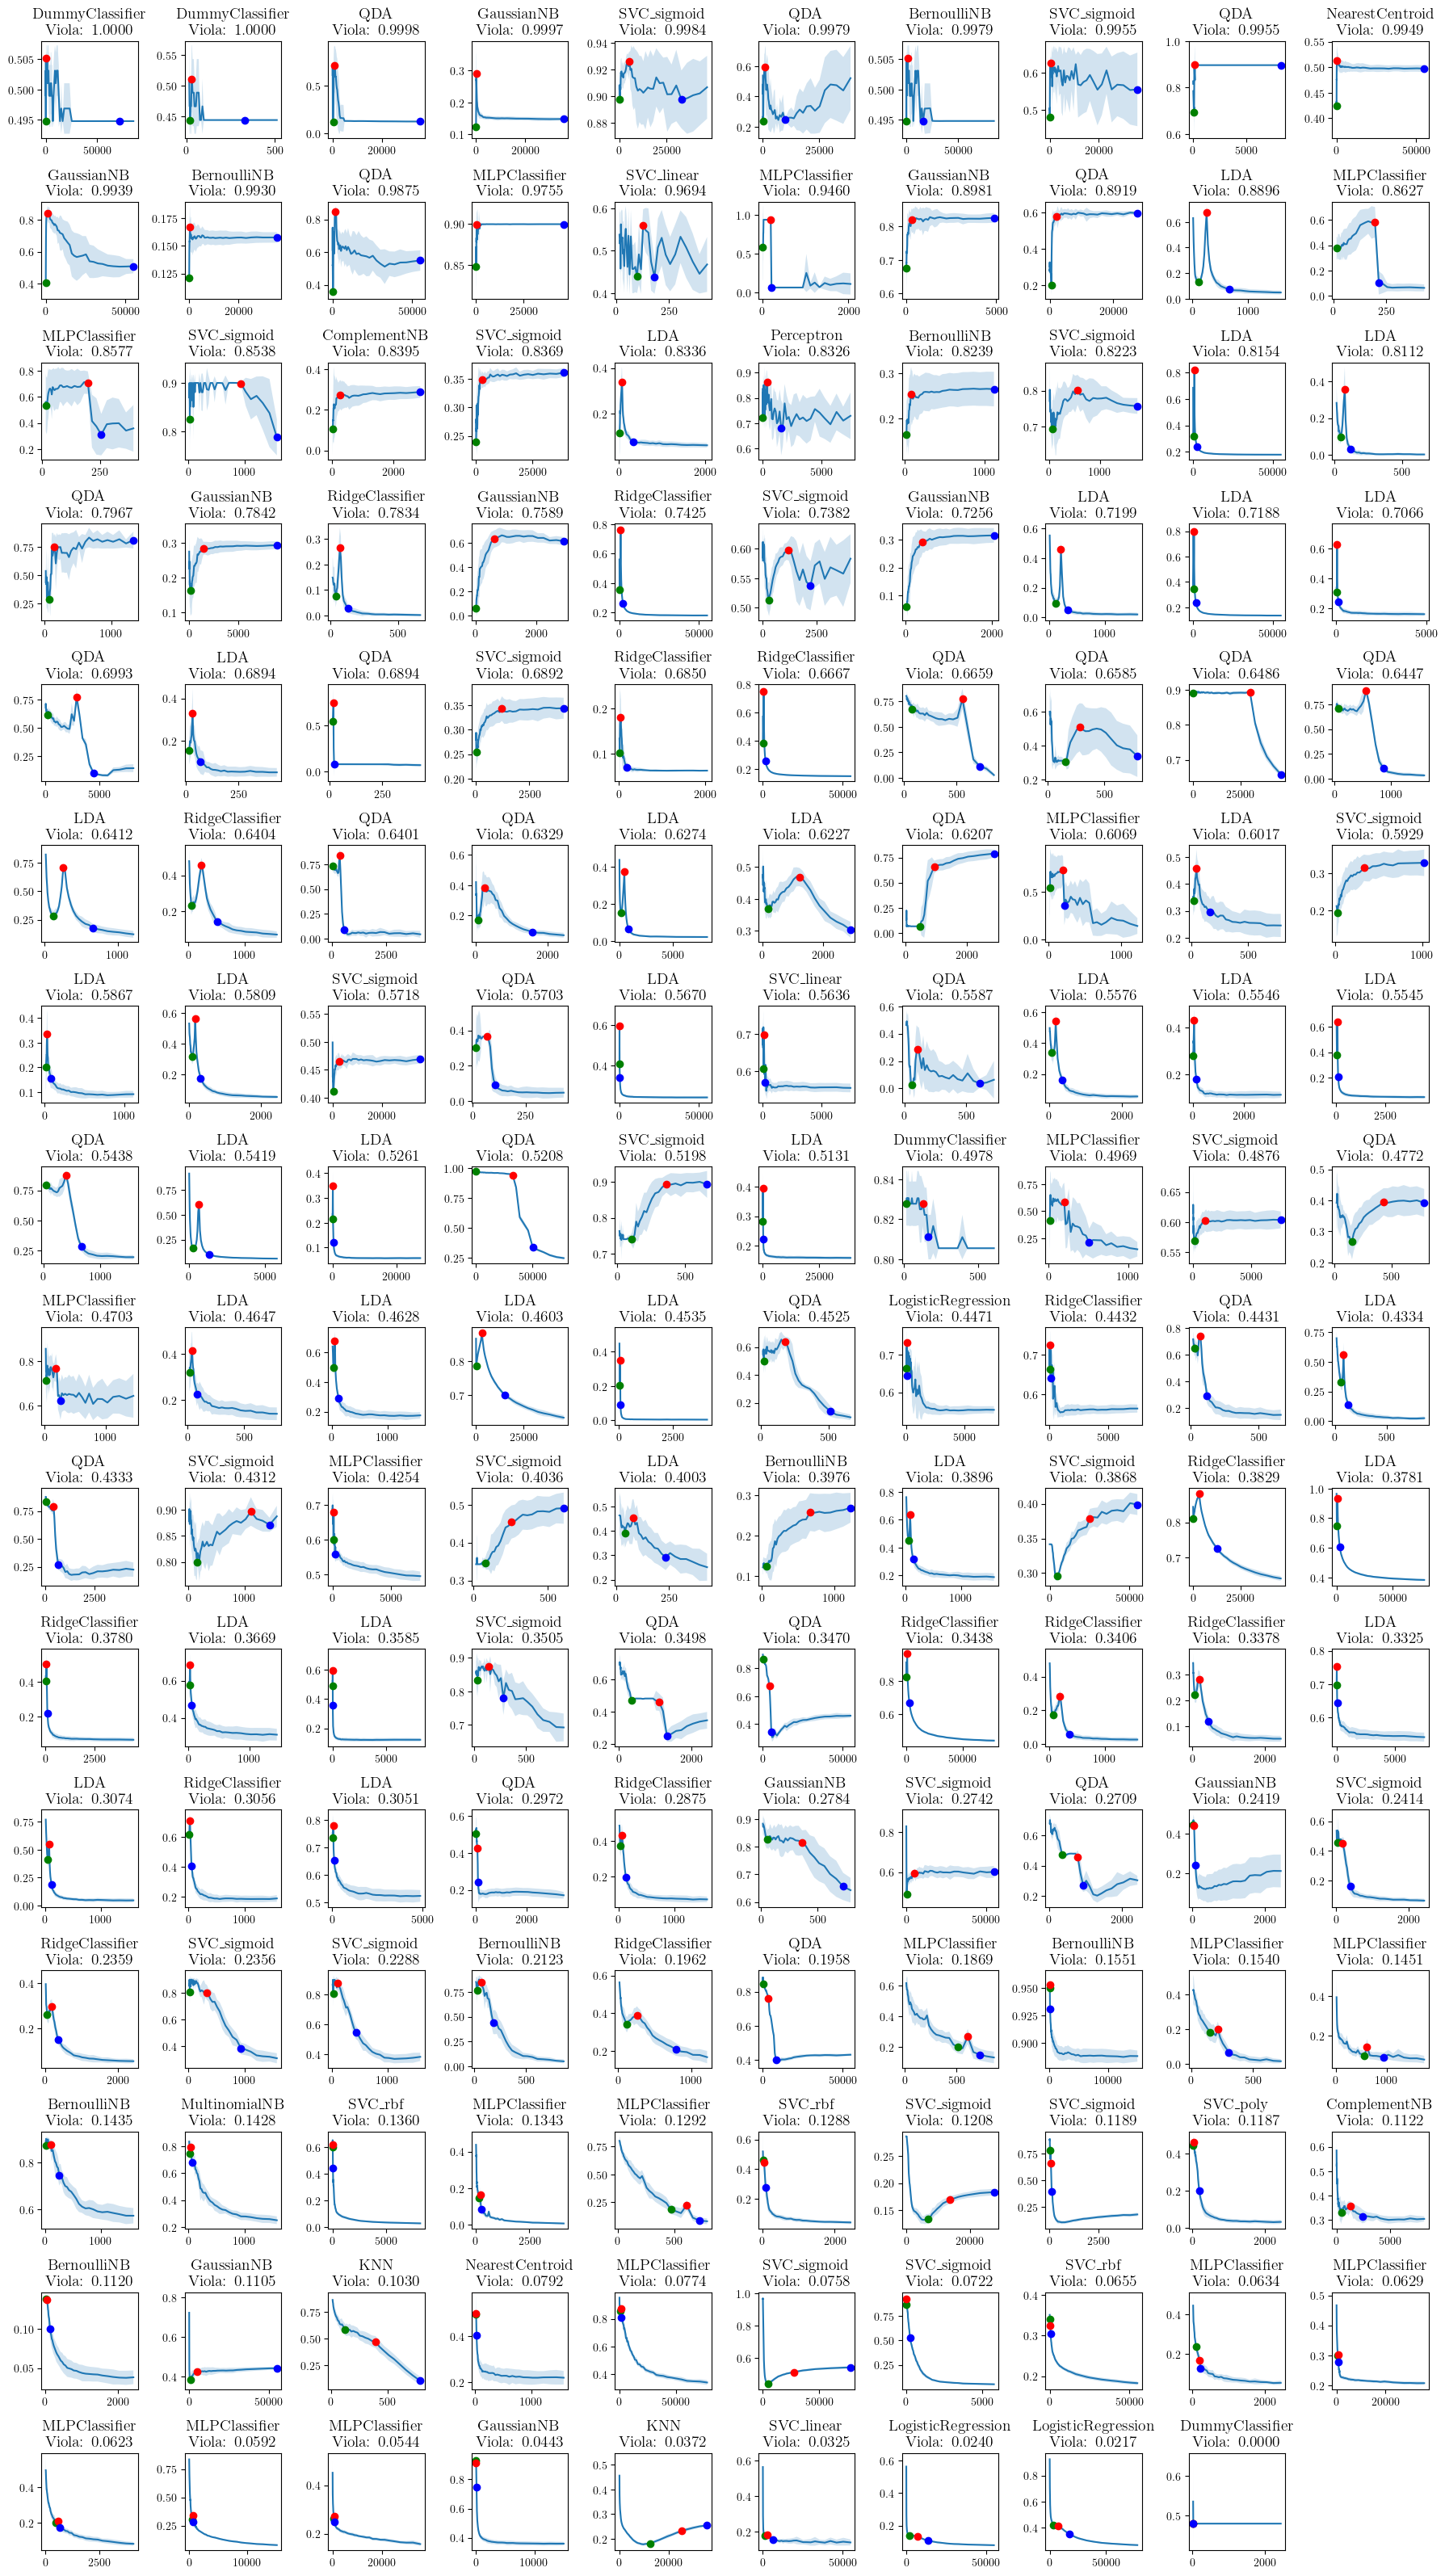

In [19]:
non_zero_indices = np.nonzero(conv_matrix)

num_non_zero = len(non_zero_indices[0])

# Define the number of columns and rows based on num_non_zero
num_columns = min(num_non_zero, 10)  # Limit columns to 10 max
num_rows = (num_non_zero // 10) + 1 if num_non_zero > 10 else 1  # Calculate rows, ensuring at least 1

# flatten
flattened_matrix = conv_matrix.flatten()
top_indices_flat = np.argpartition(flattened_matrix, -num_non_zero)[-num_non_zero:]
top_indices_flat_sorted = top_indices_flat[np.argsort(-flattened_matrix[top_indices_flat])]

# convert back to 2D
top_indices = np.unravel_index(top_indices_flat_sorted, conv_matrix.shape)

TRAIN_VAL_TEST = 1


fig, axes = plt.subplots(num_rows, num_columns, figsize=(18, num_rows * 2))

# Flatten axes for easy indexing
if num_non_zero > 1:
    axes = axes.flatten()
else:
    axes = [axes]  # If only one plot, make it a list to avoid indexing issues

# Plotting loop
for plot_index in range(num_non_zero): 
    learner_id = top_indices[0][plot_index]
    data_id = top_indices[1][plot_index]
    lc_clean = dataset[data_id, learner_id, :, :, :, TRAIN_VAL_TEST]
    mean_acc_clean = np.nanmean(lc_clean[:, :, :], axis=(0, 1))
    std_acc_clean = np.nanstd(lc_clean[:, :, :], axis=(0, 1))

    conv = conv_matrix[learner_id, data_id]
    data_size_h = conv_h_matrix[learner_id, data_id]
    data_size_i = conv_i_matrix[learner_id, data_id]
    data_size_j = conv_j_matrix[learner_id, data_id]

    ax = axes[plot_index]
    
    ax.plot(anchor_list_denser, mean_acc_clean)
    ax.fill_between(anchor_list_denser, mean_acc_clean - std_acc_clean, mean_acc_clean + std_acc_clean, alpha=0.2)

    ax.plot(data_size_h, mean_acc_clean[np.where(anchor_list_denser == data_size_h)[0][0]], 'o', color='green', label="h")
    ax.plot(data_size_i, mean_acc_clean[np.where(anchor_list_denser == data_size_i)[0][0]], 'o', color='red', label="i")
    ax.plot(data_size_j, mean_acc_clean[np.where(anchor_list_denser == data_size_j)[0][0]], 'o', color='blue', label="j")
    
    # ax.legend()

    # ax.set_xscale('log')
    ax.set_title(f"{learner_zoo[learner_id]} \n Viola: {conv:.4f}", fontsize=14)

# Hide any unused subplots if num_non_zero is not a multiple of 10
for ax in axes[num_non_zero:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


learner: 12, dataset: 6


C:\Users\cyan1\AppData\Local\Temp\ipykernel_26080\3462086965.py:21: RuntimeWarning: Mean of empty slice
  mean_clean = np.nanmean(lc_clean[:, :, :], axis=(0, 1))


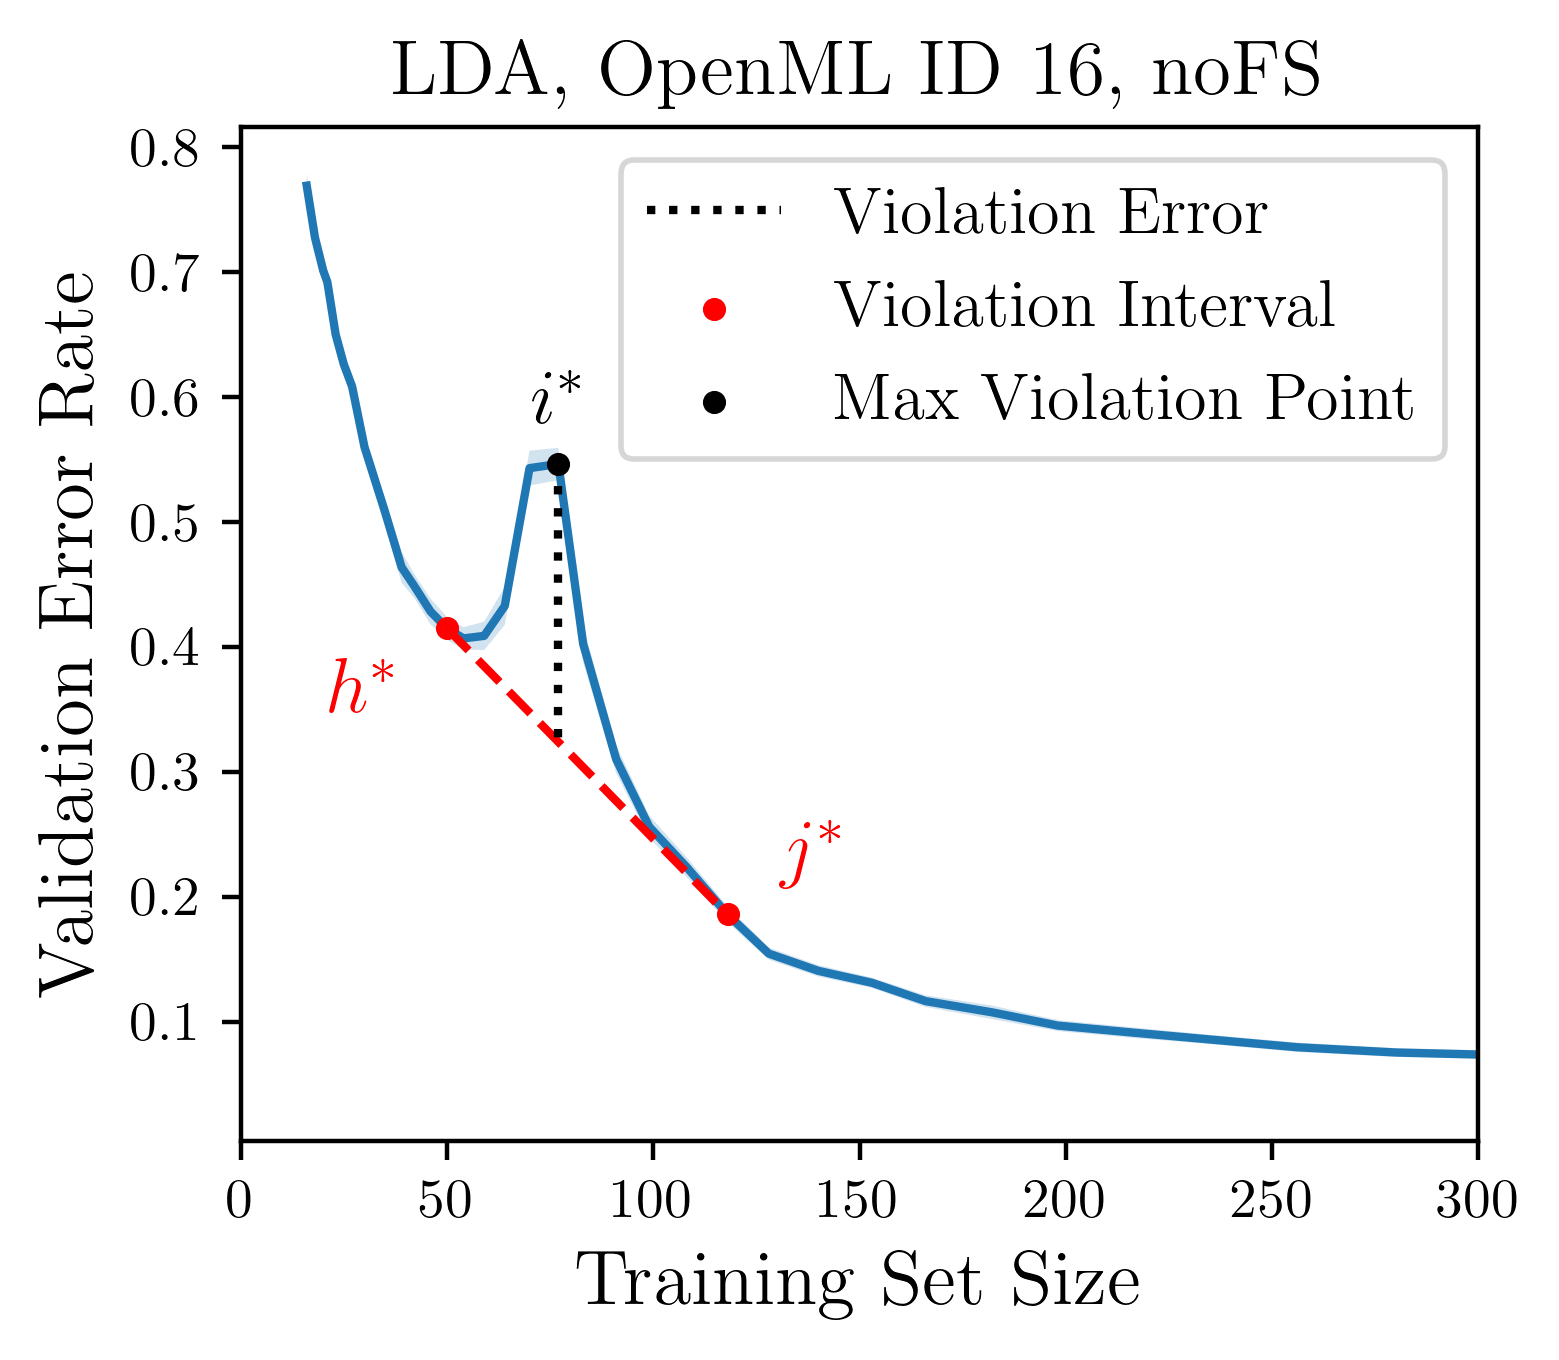

In [14]:
LEARNER = random.randint(0,23)
DATASET = random.randint(0,72)

LEARNER = 11
DATASET = 3

LEARNER = 12
DATASET = 6

# LEARNER = 21
# DATASET = 71

# LEARNER = 3
# DATASET = 13


print(f"learner: {LEARNER}, dataset: {DATASET}")


lc_clean = dataset_nofs[DATASET, LEARNER, :, :, :, 1]
mean_clean = np.nanmean(lc_clean[:, :, :], axis=(0, 1))
se_clean = np.nanstd(lc_clean[:, :, :], axis=(0, 1), ddof=1) / np.sqrt(np.sum(~np.isnan(lc_clean[:, :, :]), axis=(0, 1)))

plt.figure(figsize=(4, 3.5), dpi=400)
plt.plot(anchor_list_denser, mean_clean)#, label="LCDB 1.1 noFS")
plt.fill_between(anchor_list_denser, mean_clean - se_clean, mean_clean + se_clean, alpha=0.2)

num_points = len(mean_clean)
triple_indices = [(h, i, j) for h in range(num_points - 2) 
                    for i in range(h + 1, num_points - 1) 
                    for j in range(i + 1, num_points)]

# find maximum convexity violation i
max_violation = 0 
h_index, i_index, j_index = None, None, None

# loop all (h, i, j)
for (h, i, j) in triple_indices:
    # mid point
    uneven_ratio_j = (anchor_list_denser[i] - anchor_list_denser[h]) / (anchor_list_denser[j] - anchor_list_denser[h]) 
    uneven_ratio_h = (anchor_list_denser[j] - anchor_list_denser[i]) / (anchor_list_denser[j] - anchor_list_denser[h])
    mid_point_hj = mean_clean[h] * uneven_ratio_h + mean_clean[j] * uneven_ratio_j 
    # diff
    violation = mean_clean[i] - mid_point_hj

    if violation > max_violation:
        max_violation = violation
        h_index, i_index, j_index = h, i, j

if i_index is not None and j_index is not None:
    x1, x2 = anchor_list_denser[h_index], anchor_list_denser[j_index]
    y1, y2 = mean_clean[h_index], mean_clean[j_index]
    x_, y_ = anchor_list_denser[i_index], mean_clean[i_index]

    # h* and j* 
    plt.plot([x1, x2], [y1, y2], 'r--', linewidth=1.5, zorder=4)
    # violation error
    plt.vlines(x_, ymin=y_, ymax=(y1*(x2-x_)/(x2-x1)+y2*(x_-x1)/(x2-x1)), colors='black', linestyles='dotted', linewidth=1.5, zorder=4, label = 'Violation Error')

    plt.scatter([x1, x2], [y1, y2], color='red', s=10, zorder=5, label = 'Violation Interval')  
    plt.scatter(x_, y_, color='black', s=10, zorder=5, label = 'Max Violation Point')  

    plt.text(x1-20, y1-0.08, '$h^*$', fontsize=14, ha='center', va='bottom', color='red')  
    plt.text(x2+20, y2 + 0.02, '$j^*$', fontsize=14, ha='center', va='bottom', color='red')
    plt.text(x_, y_ +0.02, '$i^*$', fontsize=14, ha='center', va='bottom', color='black')

plt.title(f'{learner_zoo[LEARNER]}, OpenML ID {dataset_ids_CC18[DATASET]}, noFS', fontsize=14)
plt.xlabel('Training Set Size', fontsize=14)
plt.ylabel('Validation Error Rate', fontsize=14)
plt.xlim(0,300)
# plt.xscale('log')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
